In [1]:
import zipfile
import os

# Define the file path for the uploaded zip file
uploaded_zip_path = "nfl-big-data-bowl-2025.zip"  # Change if the uploaded file has a different name
extracted_path = "nfl-big-data-bowl-2025/"

# Extract the zip file
with zipfile.ZipFile(uploaded_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# List the extracted files
extracted_files = os.listdir(extracted_path)
print("Extracted Files:", extracted_files)

Extracted Files: ['plays.csv', 'tracking_week_5.csv', 'tracking_week_4.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_3.csv', 'tracking_week_2.csv', 'tracking_week_1.csv', 'players.csv', 'games.csv', 'tracking_week_9.csv', 'tracking_week_8.csv', 'player_play.csv']


In [3]:
import pandas as pd

players = pd.read_csv('nfl-big-data-bowl-2025/players.csv')
player_play = pd.read_csv('nfl-big-data-bowl-2025/player_play.csv')
plays = pd.read_csv('nfl-big-data-bowl-2025/plays.csv')

te_players = players[players['position'] == 'TE']

te_data = player_play.merge(te_players, on='nflId').merge(plays, on=['gameId', 'playId'])

# Add pre-snap alignment categories (Inline, Slot, Wide) based on receiverAlignment
def categorize_alignment(alignment):
    if alignment == '0x0':  # Inline alignment
        return 'Inline'
    elif alignment in ['1x0', '2x0']:  # Slot alignment
        return 'Slot'
    elif alignment in ['1x1', '2x1', '3x1']:  # Wide alignment
        return 'Wide'
    else:
        return 'Other'

te_data['alignment'] = te_data['receiverAlignment'].apply(categorize_alignment)

print("Tight End Data with Alignments:")
print(te_data[['nflId', 'alignment', 'yardsGained', 'inMotionAtBallSnap']].head())

Tight End Data with Alignments:
   nflId alignment  yardsGained inMotionAtBallSnap
0  47879     Other            6              False
1  47879     Other            7              False
2  47879      Wide            7              False
3  47879      Wide            6              False
4  47879     Other           12              False


Impact of Alignment on Yards Gained:
  alignment  AvgYardsGained  TotalPlays
0     Other        5.366965       10486
1      Slot        2.517647          85
2      Wide        5.275300       10425


/var/folders/8k/f0b3bqcd1nz0lfs8129s64h40000gn/T/ipykernel_14663/3501950278.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=te_alignment, x='alignment', y='AvgYardsGained', palette='coolwarm')


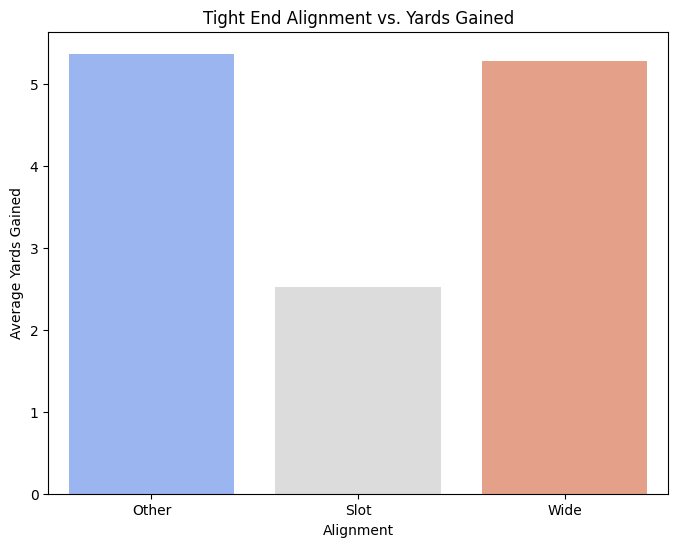

In [10]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze success rates and yardage by alignment
te_alignment = te_data.groupby('alignment').agg({
    'yardsGained': 'mean',  # Average yards gained
    'playId': 'count'  # Number of plays
}).rename(columns={'playId': 'TotalPlays', 'yardsGained': 'AvgYardsGained'}).reset_index()

print("Impact of Alignment on Yards Gained:")
print(te_alignment)

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(data=te_alignment, x='alignment', y='AvgYardsGained', palette='coolwarm')
plt.title('Tight End Alignment vs. Yards Gained')
plt.xlabel('Alignment')
plt.ylabel('Average Yards Gained')
plt.show()

Tight End Impact on Run vs Pass Plays:
  alignment  isDropback  AvgYardsGained  TotalPlays PlayType
0     Other       False        3.962047        4084      Run
1     Other        True        6.263199        6402     Pass
2      Slot       False        2.816901          71      Run
3      Slot        True        1.000000          14     Pass
4      Wide       False        4.316057        5113      Run
5      Wide        True        6.198607        5312     Pass


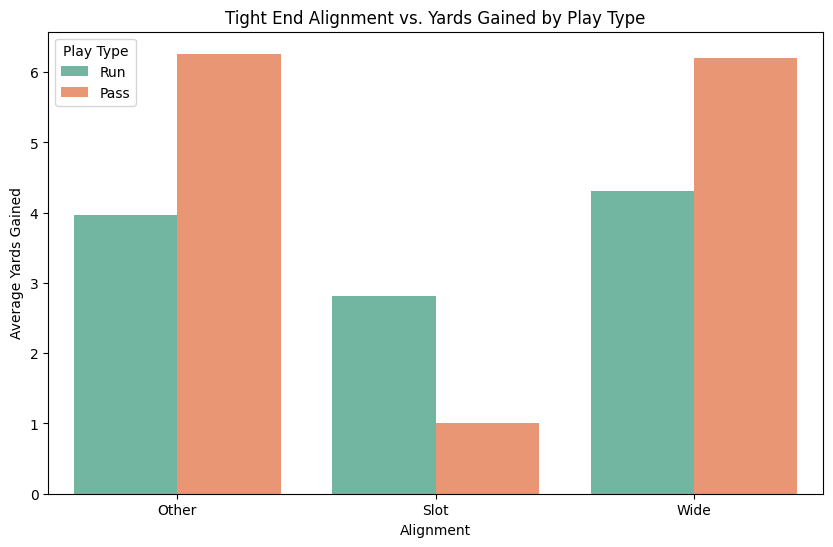

In [11]:
# Analyze TE involvement in run vs pass plays
te_run_pass = te_data.groupby(['alignment', 'isDropback']).agg({
    'yardsGained': 'mean',  # Average yards gained
    'playId': 'count'  # Number of plays
}).rename(columns={'playId': 'TotalPlays', 'yardsGained': 'AvgYardsGained'}).reset_index()

# Replace isDropback values with labels (0 = Run, 1 = Pass)
te_run_pass['PlayType'] = te_run_pass['isDropback'].apply(lambda x: 'Pass' if x == 1 else 'Run')

print("Tight End Impact on Run vs Pass Plays:")
print(te_run_pass)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=te_run_pass, x='alignment', y='AvgYardsGained', hue='PlayType', palette='Set2')
plt.title('Tight End Alignment vs. Yards Gained by Play Type')
plt.xlabel('Alignment')
plt.ylabel('Average Yards Gained')
plt.legend(title='Play Type')
plt.show()

In [14]:
import pandas as pd

# Load datasets
players_2 = pd.read_csv('nfl-big-data-bowl-2025/players.csv')  # Player-level information
player_play_2 = pd.read_csv('nfl-big-data-bowl-2025/player_play.csv')  # Player stats for each play
plays_2 = pd.read_csv('nfl-big-data-bowl-2025/plays.csv')  # Play-level data

# Filter for tight ends (position = 'TE') from players dataset
te_players = players_2[players_2['position'] == 'TE']

# Merge tight end player data with player_play and plays
te_data = player_play_2.merge(te_players, on='nflId').merge(plays_2, on=['gameId', 'playId'])

# Identify inactive players
inactive_condition = (
    (te_data['wasRunningRoute'].isna() | (te_data['wasRunningRoute'] == False)) &
    (te_data['pressureAllowedAsBlocker'].isna() | (te_data['pressureAllowedAsBlocker'] == 0)) &
    te_data['blockedPlayerNFLId1'].isna() &
    te_data['blockedPlayerNFLId2'].isna() &
    te_data['blockedPlayerNFLId3'].isna() &
    (te_data['inMotionAtBallSnap'].isna() | (te_data['inMotionAtBallSnap'] == False))
)

# Filter out inactive rows
active_te_data = te_data[~inactive_condition]

print(f"Number of rows removed as inactive: {len(te_data) - len(active_te_data)}")
print(f"Remaining active rows: {len(active_te_data)}")

# Save the filtered active_te_data to a CSV file
output_file_path = "active_te_data.csv"  # You can specify a different path if needed

active_te_data.to_csv(output_file_path, index=False)

print(f"Filtered tight end data (without inactive players) saved successfully to {output_file_path}")

# Apply categorization for alignment on active players only
def categorize_alignment(alignment):
    if alignment == '0x0':  # Inline alignment
        return 'Inline'
    elif alignment in ['1x0', '2x0']:  # Slot alignment
        return 'Slot'
    elif alignment in ['1x1', '2x1', '3x1']:  # Wide alignment
        return 'Wide'
    else:
        return 'Other'

def determine_te_action(row):
    # Case 1: Blocking
    # Check if `wasRunningRoute` is NaN and blocking ID is not NaN
    if pd.isna(row['wasRunningRoute']) and pd.notna(row['pressureAllowedAsBlocker']):
        return 'Blocker'
     # Check if running a route but not blocking
    elif pd.notna(row['wasRunningRoute']) and pd.isna(row['pressureAllowedAsBlocker']):
        return 'Route Runner'
    # Check if they are doing a chip and release
    elif pd.notna(row['wasRunningRoute']) and pd.notna(row['pressureAllowedAsBlocker']):
        return 'Chip & Release'
    # Catch-all for others
    elif pd.notna(row['inMotionAtBallSnap']):
        return 'Decoy'
    else:
        return 'Other'

# Create a copy of the filtered DataFrame
active_te_data = active_te_data.copy()

# Proceed with assignments
active_te_data['alignment'] = active_te_data['receiverAlignment'].apply(categorize_alignment)
active_te_data['te_action'] = active_te_data.apply(determine_te_action, axis=1)

print("TE Action Distribution After Filtering:\n", active_te_data['te_action'].value_counts())

Number of rows removed as inactive: 9639
Remaining active rows: 11357
Filtered tight end data (without inactive players) saved successfully to active_te_data.csv
TE Action Distribution After Filtering:
 te_action
Route Runner      8986
Blocker           1283
Chip & Release     589
Decoy              499
Name: count, dtype: int64


In [15]:
# Ensure that the DataFrame `te_data` exists with the processed data
# Save the DataFrame to a CSV file
output_file_path = "active_te_data.csv"  # Specify your desired file path

# Export te_data to a CSV file
active_te_data.to_csv(output_file_path, index=False)

print(f"Tight end data saved successfully to {output_file_path}")

Tight end data saved successfully to active_te_data.csv


/var/folders/8k/f0b3bqcd1nz0lfs8129s64h40000gn/T/ipykernel_14663/4090212866.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=te_action_distribution.index, y=te_action_distribution.values, palette='viridis')


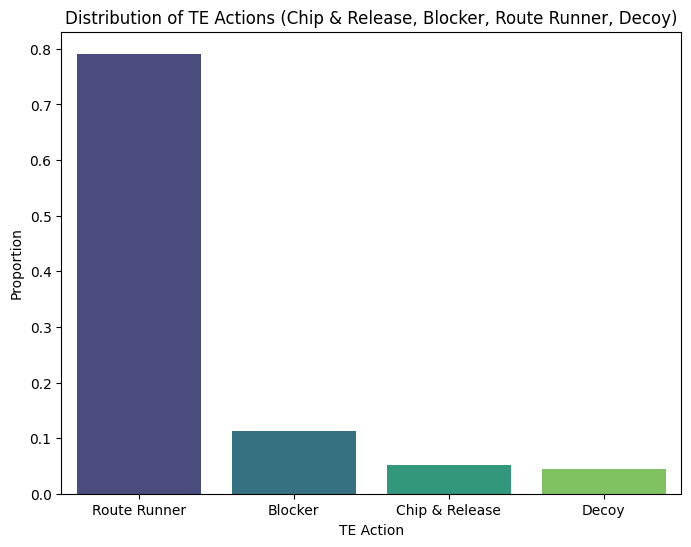

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

te_action_distribution = active_te_data['te_action'].value_counts(normalize=True)
plt.figure(figsize=(8, 6))
sns.barplot(x=te_action_distribution.index, y=te_action_distribution.values, palette='viridis')
plt.title('Distribution of TE Actions (Chip & Release, Blocker, Route Runner, Decoy)')
plt.xlabel('TE Action')
plt.ylabel('Proportion')
plt.show()

In [23]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable `te_action` with four categories
encoder = LabelEncoder()
active_te_data['te_action_encoded'] = encoder.fit_transform(active_te_data['te_action'])

# Define features and target
features = ['alignment', 'offenseFormation', 'playClockAtSnap',
            'shiftSinceLineset', 'motionSinceLineset', 'preSnapHomeScore', 'preSnapVisitorScore',
            'down', 'yardsToGo', 'quarter','absoluteYardlineNumber']
target = 'te_action_encoded'

# Ensure categorical features are encoded
for feature in ['alignment', 'offenseFormation', 'dropbackType']:
    active_te_data[feature] = LabelEncoder().fit_transform(active_te_data[feature].astype(str))

# Prepare feature matrix (X) and target vector (y)
X = active_te_data[features]
y = active_te_data[target]


Model Accuracy: 0.6241197183098591

Classification Report:
                precision    recall  f1-score   support

       Blocker       0.29      0.33      0.31       240
Chip & Release       0.11      0.05      0.07       107
         Decoy       0.15      0.91      0.26       101
  Route Runner       0.92      0.68      0.78      1824

      accuracy                           0.62      2272
     macro avg       0.37      0.49      0.35      2272
  weighted avg       0.78      0.62      0.68      2272



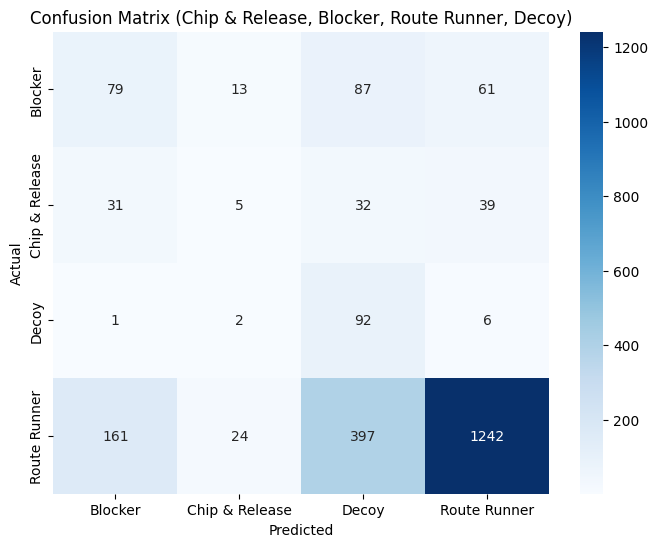

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=10, random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate the model
y_pred = dt_model.predict(X_test)

# Retrieve unique classes from the encoder that match the test data
unique_classes = list(sorted(set(y_test)))
target_names = [encoder.classes_[cls] for cls in unique_classes]

# Print Model Accuracy and Classification Report
print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Chip & Release, Blocker, Route Runner, Decoy)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Feature Importance:
                    Feature  Importance
4       motionSinceLineset    0.426206
1         offenseFormation    0.405110
10  absoluteYardlineNumber    0.045990
5         preSnapHomeScore    0.032709
2          playClockAtSnap    0.026673
8                yardsToGo    0.026551
7                     down    0.025535
6      preSnapVisitorScore    0.011226
0                alignment    0.000000
3        shiftSinceLineset    0.000000
9                  quarter    0.000000


/var/folders/8k/f0b3bqcd1nz0lfs8129s64h40000gn/T/ipykernel_14663/1716708764.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')


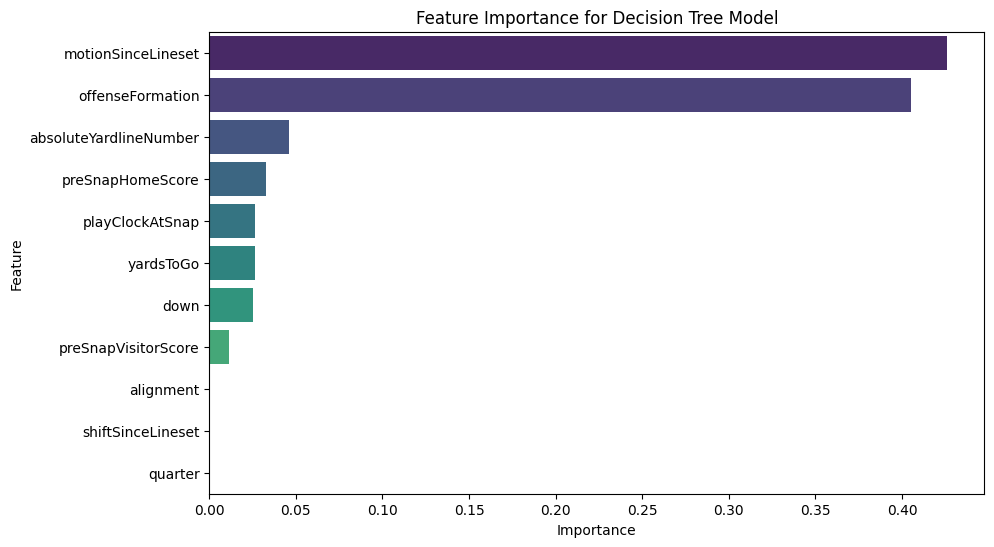

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances from the trained decision tree model
importances = pd.DataFrame({
    'Feature': features,
    'Importance': dt_model.feature_importances_
})

# Sort by importance
importances = importances.sort_values(by='Importance', ascending=False)

# Display the feature importance values
print("\nFeature Importance:\n", importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance for Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Updated feature types:
 alignment                   int64
offenseFormation            int64
playClockAtSnap           float64
shiftSinceLineset           int64
motionSinceLineset          int64
preSnapHomeScore            int64
preSnapVisitorScore         int64
down                        int64
yardsToGo                   int64
quarter                     int64
absoluteYardlineNumber      int64
dtype: object

Model Accuracy: 0.7918133802816901

Classification Report:
                precision    recall  f1-score   support

       Blocker       0.34      0.22      0.27       240
Chip & Release       0.09      0.02      0.03       107
         Decoy       0.44      0.23      0.30       101
  Route Runner       0.84      0.94      0.89      1824

      accuracy                           0.79      2272
     macro avg       0.43      0.35      0.37      2272
  weighted avg       0.74      0.79      0.76      2272



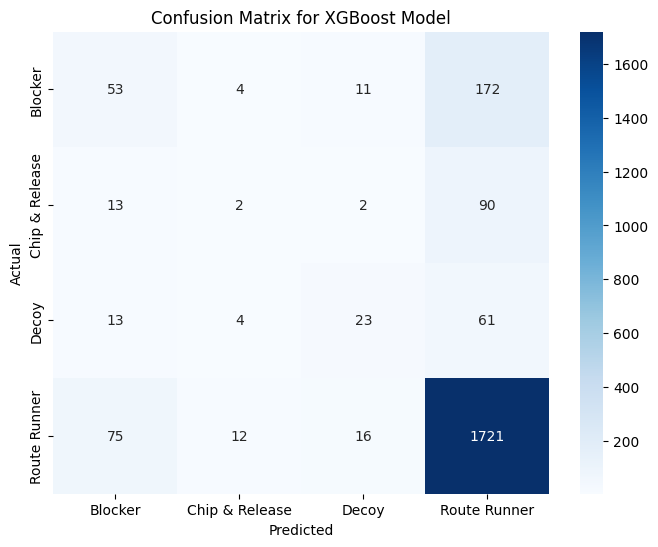

In [29]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Encode non-numeric columns
for col in ['shiftSinceLineset', 'motionSinceLineset', 'alignment', 'offenseFormation']:
    if X[col].dtype == 'object':
        encoder = LabelEncoder()
        X[col] = encoder.fit_transform(X[col].astype(str))

# Check updated dtypes
print("Updated feature types:\n", X.dtypes)

# Re-split the data after fixing the columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost classifier again
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(active_te_data['te_action_encoded'].unique()), random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=LabelEncoder().fit(active_te_data['te_action']).classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LabelEncoder().fit(active_te_data['te_action']).classes_, yticklabels=LabelEncoder().fit(active_te_data['te_action']).classes_)
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/var/folders/8k/f0b3bqcd1nz0lfs8129s64h40000gn/T/ipykernel_14663/71293773.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


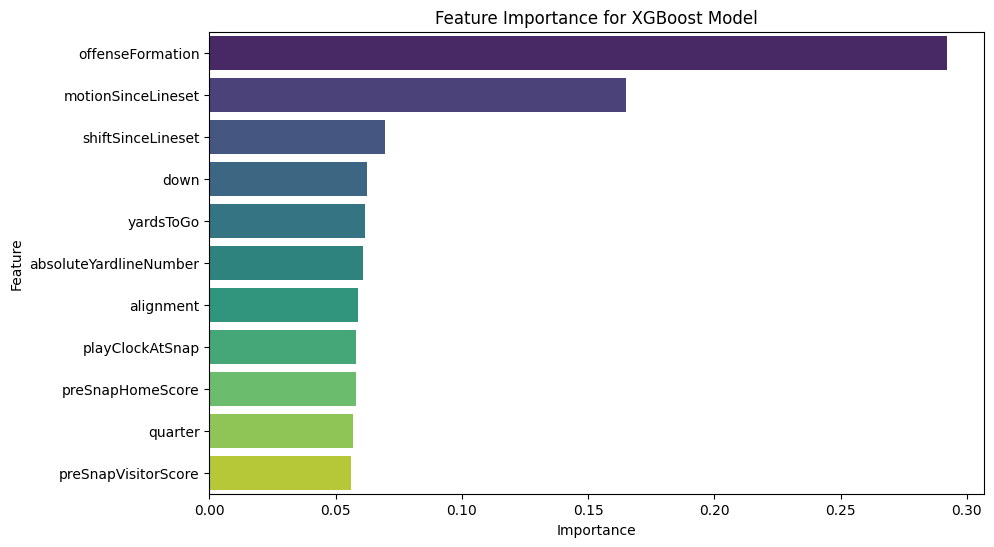

In [30]:
# Plot feature importance
import pandas as pd

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance for XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

/var/folders/8k/f0b3bqcd1nz0lfs8129s64h40000gn/T/ipykernel_14663/2690226811.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=predicted_distribution, x='Predicted', palette='viridis')


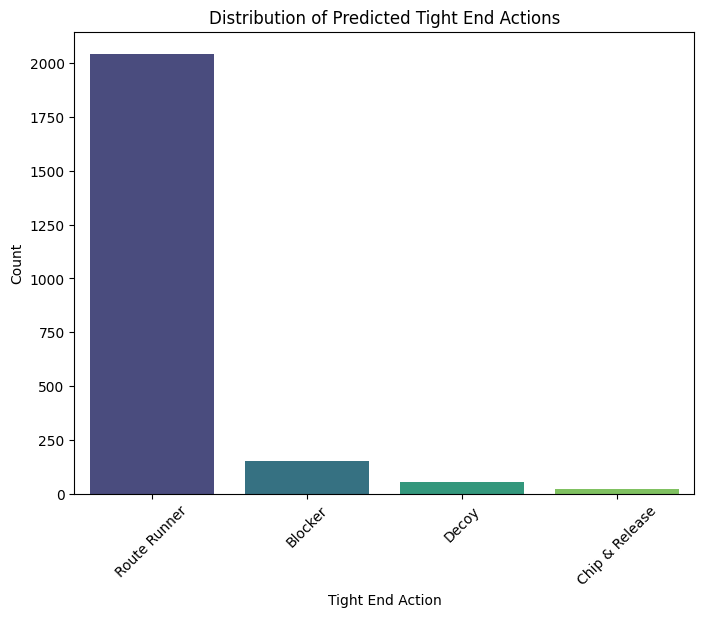

In [31]:
# Distribution of Predictions
predicted_distribution = pd.DataFrame({'Predicted': y_pred})
predicted_distribution['Predicted'] = LabelEncoder().fit(active_te_data['te_action']).inverse_transform(predicted_distribution['Predicted'])

plt.figure(figsize=(8, 6))
sns.countplot(data=predicted_distribution, x='Predicted', palette='viridis')
plt.title('Distribution of Predicted Tight End Actions')
plt.xlabel('Tight End Action')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


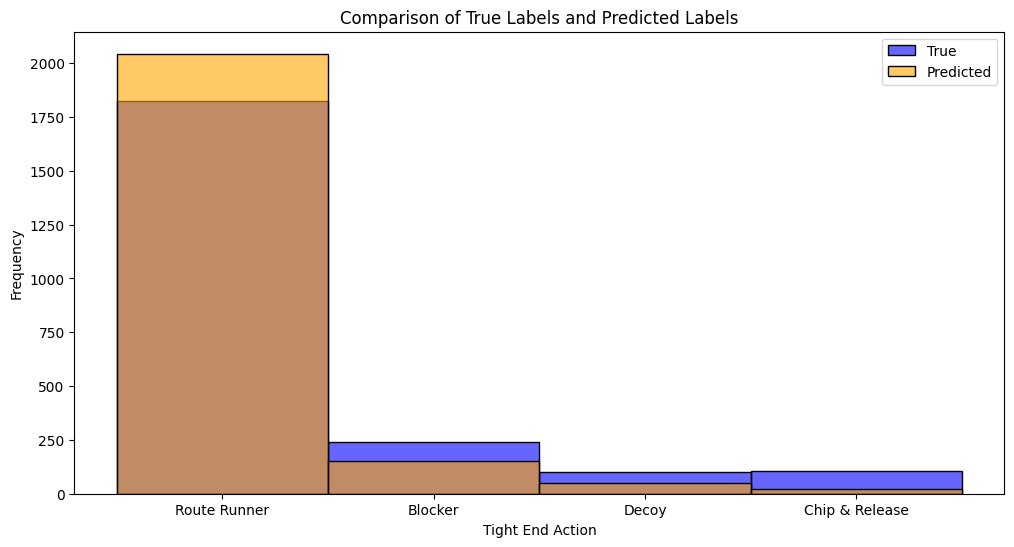

In [32]:
# Compare True Labels and Predictions
comparison_df = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
comparison_df['True'] = LabelEncoder().fit(active_te_data['te_action']).inverse_transform(comparison_df['True'])
comparison_df['Predicted'] = LabelEncoder().fit(active_te_data['te_action']).inverse_transform(comparison_df['Predicted'])

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(data=comparison_df, x='True', color='blue', label='True', alpha=0.6, kde=False)
sns.histplot(data=comparison_df, x='Predicted', color='orange', label='Predicted', alpha=0.6, kde=False)
plt.title('Comparison of True Labels and Predicted Labels')
plt.xlabel('Tight End Action')
plt.ylabel('Frequency')
plt.legend()
plt.show()